In [ ]:
# Leer ficheros de datos
import codecs
import pandas as pd
import pyarrow.parquet as pq
# Extraer información
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
# Auxiliares
import numpy as np
import logging
from typing import Union
import pyarrow as pa
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

### Cargamos el parquet

In [ ]:
df = pd.read_parquet('Datasets/PHA/PHA_Data.parquet', engine='pyarrow')


In [ ]:
df.dtypes

In [ ]:
df['c55']

### Convertimos cualquier tipo de registro faltante a NaN

In [ ]:
def clean_data(value): 
    # Si se trata de un valor en blanco sustituir a NaN 
    try: 
        if value in [None, 'nan']: 
            return np.nan 
         
        return value 
 
    except Exception as e: 
        return value 
     
# Iterar sobre todas las columnas y comprobar sus valores 
columns = len(df.columns) 
 
for column in df.columns: 
    # Utilizar compresion de listas y aplicar el filtrado de valores 
    values = [clean_data(value) for value in df[column]] 
    df[column] = values 
    columns -= 1 
    print(f'[+] REMAINING_COLUMNS\t{columns}\t', end='\r') 
     
df

### Cargamos cabecera  y convertimos a dataframe

In [ ]:
url_legend = 'https://av-info.faa.gov/data/AID/Afilelayout.txt'
# Leemos el contenido de la leyenda
with urlopen(url_legend) as content:
    soup = BeautifulSoup(content, "html.parser")
    soup_lines = str(soup).split('\r\n')

# Transformamos la respuesta en un diccionario con el nombre de la columna y la descripción
legend_df = {"Column_name": [], "Description": []}
# Recorrer las lineas con datos de lineas. Se salta las dos primeras y las tres ultimas
# filas por no tener datos relevantes de la leyenda
for line in soup_lines[2:-3]:
    # Se extrae los 5 primeros caracteres para conocer el nombre de la columna
    legend_df["Column_name"].append(line[0:5].strip())
    # Se extrae la descripcion, esta comienza en la posicion 53
    legend_df["Description"].append(line[53:].strip())
    
# Convertir el diccionario en pandas.Dataframe
legend_df = pd.DataFrame.from_dict(data=legend_df)
legend_df

### Enumeramos las cabecera con la descripción para poder verlas mejor y seleccionamos las columnas que podrían ser relevantes

In [ ]:
used_columns = ['c1', 'c6', 'c7', 'c8', 'c10', 'c132', 'c134', 'c136', 'c138', 'c141', 'c160', 'c162', 'c23', 'c24', 'c11', 'c14', 'c20', 'c21', 'c102', 'c104', 'c106', 'c108', 'c110', 'c114', 'c115', 'c117', 'c118', 'c61', 'c62', 'c65', 'c67', 'c68', 'c41', 'c45', 'c47', 'c49', 'c50', 'c52', 'c53', 'c54', 'c55', 'c56', 'c120', 'c121', 'c122', 'c126', 'c127', 'c128', 'c130', 'c78', 'c80', 'c82', 'c84', 'c86', 'c88', 'c90', 'c92', 'c94', 'c96', 'c44', 'c46', 'c48', 'c51', 'c229', 'c230']
#used_columns = [f'c{idx}' for idx in used_columns]

for col in used_columns:
    description = legend_df[legend_df["Column_name"] == col]["Description"].values[0]
    print(f'[+]  Descripción columnas\t{col}\t{description}')
   

### Creamos dataframe a partir del primario usando solamente las columnas de la lista anteriormente  generada

In [ ]:
data= df.loc[:, used_columns]

### Realizamos un conteo de los datos faltantes NaN de las columnas que pueden ser potenciales

In [ ]:
# Contar el número de valores NaN en cada columna
print(data.isna().sum())

### Procedemos a borrar las columnas con demasiados datos faltantes (más de 100.000 unidades) y las filas que tengan más de 3 valores faltantes

In [ ]:
#Borramos columnas que tengan más de 100.000 datos faltantes  
data = data.dropna(thresh=100000, axis=1)
data = data.dropna(thresh=3)

### Volvemos a contar despues del borrado para ver que columnas son aprovechables

In [ ]:
# Contar el número de valores NaN en cada columna
print(data.isna().sum())



In [ ]:
columnas = list(data.columns)
#unused_columns = [5, 3, 2, 4, 9, 75, 140, 139, 203, 204, 214, 790, 26, 37, 15, 16, 17,18, 19, 143, 205, 206, 207, 208, 210, 43, 129, 124, 125, 77]
#unused_columns = [f'c{idx}' for idx in unused_columns]

for col in columnas:
    description = legend_df[legend_df["Column_name"] == col]["Description"].values[0]
    print(f'[+] Descripción columnas\t{col}\t{description}')

# ESTUDIO DE COLUMNAS PARA SABER CUALES SON CATEGORICAS Y CUALES NUMERICAS PARA PROCEDER SEGUIDAMENTE A LA IMPUTACIÓN

Si se optara por hacerlo de forma automatica hay atributos que se clasificaran como categoricos cuando no lo son y viceversa
Por lo que hay que proceder a hacerlo manualmente mediante dos pasos:
En el primer paso se comprueba la cantidad de valores unicos clasificando los que superan los 100 valores como numericos. 
En segundo lugar hay que comprobar que los valores no unicos no contengan string


### Primer paso

In [ ]:
# con  un sencillo for podemos apreciar la cantidad de valores unicos de cada columna
# vamos a establecer que los que tengan más de 100 valores unicos son numericos y los restantes categoricos

for col in data.columns:
    print(col, data[col].nunique())

In [ ]:
#Vamos a establecer como criterio de clasificación las que superen 100 caracteres unicos serán numericas
#las restantes serán categoricas

# Definimos una lista para almacenar las columnas numéricas
num_cols = []

# Definimos una lista para almacenar las columnas categóricas
cat_cols = []

# Verificamos la cardinalidad de cada columna
for col in data.columns:
    unique_vals = data[col].nunique()
    if unique_vals >= 100:
        num_cols.append(col)
    else:
        cat_cols.append(col)

# Imprimimos las columnas numéricas y categóricas
print("Columnas numéricas:", num_cols)
print("Columnas categóricas:", cat_cols)

In [ ]:
for col in num_cols:
    try:
        numeric_values = pd.to_numeric(data[col])
        non_numeric_values = numeric_values.isna().sum()
        print(f"La columna '{col}' tiene {non_numeric_values} valores no numéricos (excluyendo NaN)")
    except ValueError:
        print(f"La columna '{col}' contiene valores no numéricos")

### Segundo paso

In [ ]:
for i in num_cols:
    print(data[i])

In [ ]:
for i in cat_cols:
    print(data[i])

Hay que añadir las columnas con  texto es decir que no son tipo numerico y pasarlas a categoricas.

In [ ]:
cat_cols=['c1', 'c6', 'c7', 'c8', 'c132', 'c134', 'c141', 'c11', 'c102', 'c104', 'c106', 'c108', 'c110', 'c65', 'c67', 'c68', 'c41', 'c45', 'c47', 'c49', 'c50', 'c52', 'c130', 'c80', 'c82', 'c94', 'c96', 'c44', 'c46', 'c48', 'c51','c23','c24','c14','c78']
num_cols= ['c10', 'c61', 'c62', 'c53', 'c54', 'c55', 'c56']

In [ ]:
data.dtypes

In [ ]:
import re
patron = re.compile(r'[^\w\s.,ñáéíóú,$]')
for columna in data.columns:
    for indice, valor in data[columna].iteritems():
        # Buscar caracteres raros en la celda actual
        resultado = patron.search(str(valor))
        if resultado:
            print(f"Caracter raro encontrado en la columna {columna}, fila {indice}: '{resultado.group(0)}'")

In [ ]:
data["c10"] = data["c10"].apply(pd.to_numeric, downcast='float', errors='coerce')

In [ ]:
data['c10']

In [ ]:
data.dtypes

# Imputación

## Imputación simple y menos precisa

## Imputación más exacta pero más costosa computacionalmente

#### Imputación de columnas  numericas

In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer, IterativeImputer

# Imputación para columnas numéricas
#num_cols = data.select_dtypes(include=['float', 'int']).columns.tolist()
num_imputer = KNNImputer(n_neighbors=5)
data[num_cols] = num_imputer.fit_transform(data[num_cols])



In [ ]:
data[num_cols]

In [ ]:
data.dtypes

In [ ]:
data[cat_cols]

#### Imputación de columnas categoricas

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

df_imputed = data
# Imputación de valores categóricos
#cat_cols = data.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col].astype(str))

imputer = KNNImputer()
df_imputed[cat_cols] = imputer.fit_transform(df_imputed[cat_cols])

# Convertir de vuelta a valores categóricos
for col in cat_cols:
    le = LabelEncoder()
    le.fit(df_imputed[col].astype(int))
    df_imputed[col] = le.inverse_transform(df_imputed[col].astype(int))

In [ ]:
df_imputed.dtypes

In [ ]:
data

In [ ]:
print(data.isna().sum())
print(data.shape)

In [ ]:
data.dtypes

In [ ]:
for col in data.columns:
    print(col, data[col].nunique())

# Pasamos a parquet con los datos ya imputados para no tener que imputarlo cada vez que utilicemos el código

In [ ]:
data.to_parquet("data_tratamiento.parquet")

AL LEER EL PARQUET TODOS LOS ATRIBUTOS APARECEN COMO NUMERICOS O FLOAT Y NINGUNO CATEGORICO POR LO QUE TENDREMOS QUE VOLVER A INDICAR CUALES SON CATEGORICOS Y CULES NO

### Ver relación entre caracteristicas (uso de SKEW())para ver como se relacionan los atributos y poder ver también si presentan valores atipicos

In [1]:
# Leer ficheros de datos
import codecs
import pandas as pd
import pyarrow.parquet as pq
# Extraer información
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
# Auxiliares
import numpy as np
import logging
from typing import Union
import pyarrow as pa
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression




#Leemos parquet y generamos dataframe para seguir trabajando con el
data = pd.read_parquet('data_tratamiento.parquet', engine='pyarrow')

In [2]:
data.skew()

c1        0.008335
c6        0.494655
c7       -0.249906
c8        0.031915
c10      -0.191039
c132     -0.626479
c134     -1.115115
c141     -0.895851
c23       0.637721
c24       0.284735
c11      -0.071275
c14       0.020488
c102      0.888486
c104      0.035139
c106      0.522044
c108     -1.629720
c110      1.181733
c61       8.018098
c62       8.127526
c65       3.542569
c67       4.882461
c68       3.709861
c41       0.915107
c45       0.095859
c47       0.724536
c49      -0.037534
c50       0.565508
c52      -0.908156
c53      10.069240
c54       2.226728
c55     388.206970
c56       2.838843
c130      0.254395
c78       0.009613
c80      -1.809884
c82       0.039518
c94       0.124193
c96       0.587532
c44       0.473579
c46       0.157065
c48      -3.158223
c51      -1.233649
dtype: float64

Podemos verque una de los atributos concretamente el c55 es posible que tenga un valor atípico dada la desviacion que tiene

Seguidamente hacemos un boxplot para poder confirmar si presenta valores atipicos 

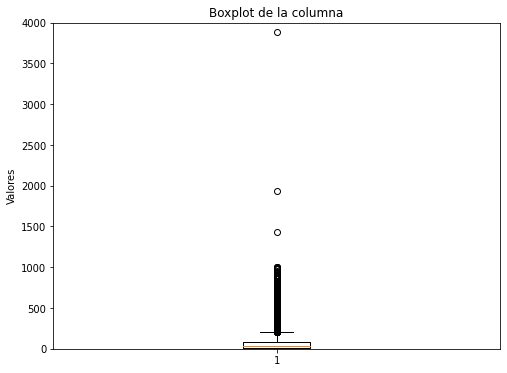

In [3]:
# Crear un boxplot de una sola columna del dataframe
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(data['c55'])

# Personalizar el gráfico
ax.set_title('Boxplot de la columna')
ax.set_ylabel('Valores')
plt.ylim(0, 4000)
# Mostrar el gráfico
plt.show()

Efectivamente es muy posible, contaremos ahora la cantidad de filas en las que se repiten estos valores para poder ver si es algo frecuente o es algo puntual que tiene bastante probabilidad de ser valor erroneo

In [4]:
# Supongamos que la columna se llama 'nombre_columna' y está en el dataframe 'df'
conteo = data['c55'].between(1200, 4000, inclusive=True).sum()

print(f"El número de filas con valor entre 2000 y 4000 es: {conteo} de {len(data)} filas totales del dataframe")

El número de filas con valor entre 2000 y 4000 es: 3 de 214875 filas totales del dataframe


C:\Users\Neuraprint\AppData\Local\Temp\ipykernel_11144\3049402055.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  conteo = data['c55'].between(1200, 4000, inclusive=True).sum()


Procederemos a eliminar esos tres registros  que tomaremos como erroneos

In [5]:
columna = data['c55']
mascara = columna.between(1200, 4000, inclusive=True)
#mascara.count() 
data = data[~mascara].dropna()

conteo = data['c55'].between(1200, 4000, inclusive=True).sum()
print(f"El número de filas con valor entre 2000 y 4000 es: {conteo} de {len(data)} filas totales del dataframe")

El número de filas con valor entre 2000 y 4000 es: 0 de 214872 filas totales del dataframe


C:\Users\Neuraprint\AppData\Local\Temp\ipykernel_11144\2277819193.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  mascara = columna.between(1200, 4000, inclusive=True)
C:\Users\Neuraprint\AppData\Local\Temp\ipykernel_11144\2277819193.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  conteo = data['c55'].between(1200, 4000, inclusive=True).sum()


Tras el tratamiento a la posibilidad de valores erraticos debido a la desviación que presenta la columna c55 observamos que los datos son aparentemente correctos y es la naturaleza de los mismos la que produce esa desviación.C6 aparenta tener el mismo problema pero es también debido a que es una fecha.

In [6]:
data.skew()

c1        0.008345
c6        0.494687
c7       -0.249914
c8        0.031919
c10      -0.191054
c132     -0.626456
c134     -1.115097
c141     -0.895834
c23       0.637715
c24       0.284715
c11      -0.071271
c14       0.020512
c102      0.888535
c104      0.035164
c106      0.522073
c108     -1.629725
c110      1.181798
c61       8.018041
c62       8.127468
c65       3.542582
c67       4.882423
c68       3.709830
c41       0.915134
c45       0.095885
c47       0.724580
c49      -0.037515
c50       0.565544
c52      -0.908152
c53      10.069439
c54       2.226785
c55     389.220829
c56       2.838876
c130      0.254426
c78       0.009621
c80      -1.809864
c82       0.039547
c94       0.124220
c96       0.587561
c44       0.473616
c46       0.157091
c48      -3.158231
c51      -1.233635
dtype: float64

# Escalar los datos

In [7]:
from sklearn.preprocessing import StandardScaler

cat_cols=['c1', 'c6', 'c7', 'c8', 'c132', 'c134', 'c141', 'c11', 'c102', 'c104', 'c106', 'c108', 'c110', 'c65', 'c67', 'c68', 'c41', 'c45', 'c47', 'c49', 'c50', 'c52', 'c130', 'c80', 'c82', 'c94', 'c96', 'c44', 'c46', 'c48', 'c51','c23','c24','c14','c78']
num_cols= ['c10', 'c61', 'c62', 'c53', 'c54', 'c55', 'c56']

df = pd.DataFrame(data)
print(df.dtypes)
# Seleccionamos los atributos numéricos y los estandarizamos
#num_cols = df.select_dtypes(include=['int', 'float']).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Creamos un nuevo dataframe con los datos categóricos y los datos numéricos estandarizados
#cat_cols = df.select_dtypes(include=['object']).columns
df = pd.concat([df[cat_cols], df[num_cols]], axis=1)

print(df)

c1        int32
c6        int32
c7        int32
c8        int32
c10     float64
c132      int32
c134      int32
c141      int32
c23       int32
c24       int32
c11       int32
c14       int32
c102      int32
c104      int32
c106      int32
c108      int32
c110      int32
c61     float64
c62     float64
c65       int32
c67       int32
c68       int32
c41       int32
c45       int32
c47       int32
c49       int32
c50       int32
c52       int32
c53     float64
c54     float64
c55     float64
c56     float64
c130      int32
c78       int32
c80       int32
c82       int32
c94       int32
c96       int32
c44       int32
c46       int32
c48       int32
c51       int32
dtype: object
        c1  c6  c7  c8  c132  c134  c141  c11  c102  c104  ...   c24    c14  \
0        0   1   0   0    26    17     9    3     0    17  ...  2111  14534   
1        0   1   0   0    26    17     9    7     0    14  ...   486  12717   
2        0   1   0   0    26    17     9   14     7     9  ...   375  11266  

Una vez ya realizado el tratamiento de los datos guardamos en un .parquet para proseguir con la predicción

In [8]:
df.to_parquet("data_tratamiento_escalado.parquet")

# Predecir

In [ ]:
Predicción ejecutada en keras por problemas de ejecución en equipo local

https://www.kaggle.com/josepy/prediccion-final/edit